In [1]:
from JupyterImport import *
from src.DataStandardize.ExpSpecific.Sep20 import Fixes
root_logger.setLevel(logging.WARNING)
from src.Scripts.SquareEntropyAnalysis import *

In [2]:
analysis_params = EA_params(bin_data=True, num_per_row=400,
                            sub_line=False, sub_line_range=(-4000, -500),
                            int_entropy_range=(600, 1000),
                            allowed_amp_range=(0.8, 1.2), default_amp=1.05,
                            allowed_dT_range=(1, 15), default_dT=5.96,
                            CT_fit_range=(None, None),
                            fit_param_edit_kwargs=dict())



In [3]:
dats = get_dats((1362, 1383 + 1), overwrite=False)  # Same as above but around -100mT

p1_dats = [dat for dat in dats if dat.Logs.part_of[0] == 1]
p2_dats = [dat for dat in dats if dat.Logs.part_of[0] == 2]
dat_pairs = list(zip(p1_dats, p2_dats))

recalculate = False
for dat in dats:
    Fixes.fix_magy(dat)
    Fixes.setpoint_averaging_fix(dat)
    
for dat in dats:
    if not hasattr(dat.Other, 'time_processed') or recalculate:
        standard_square_process(dat, analysis_params)  # This runs and saves all the stuff in dat.Other.EA_... (for Entropy Analysis...)

100% (22 of 22) |########################| Elapsed Time: 0:00:04 Time:  0:00:04


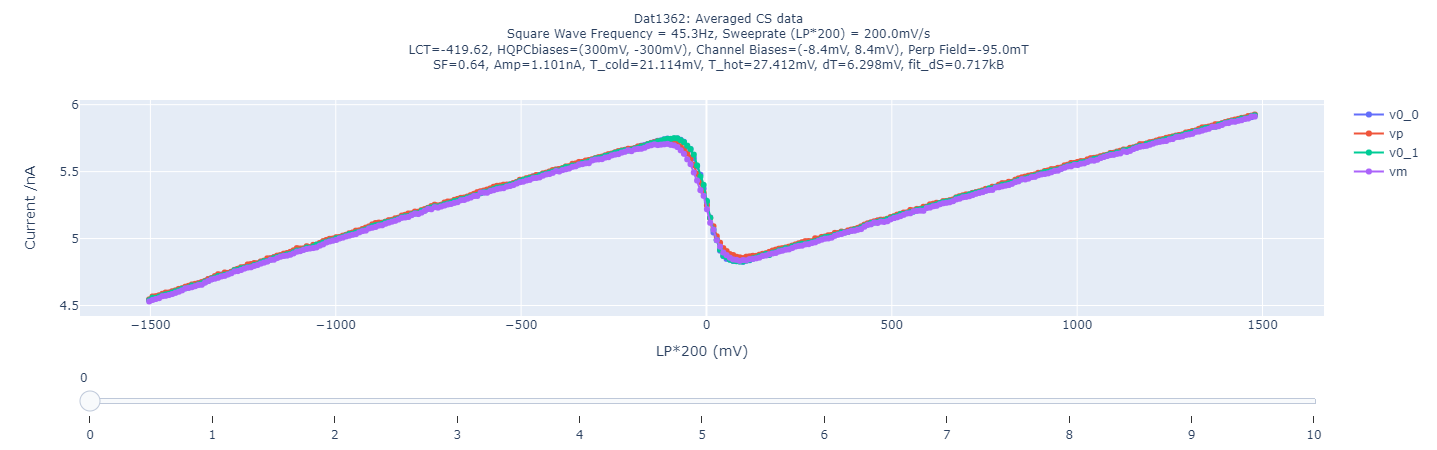

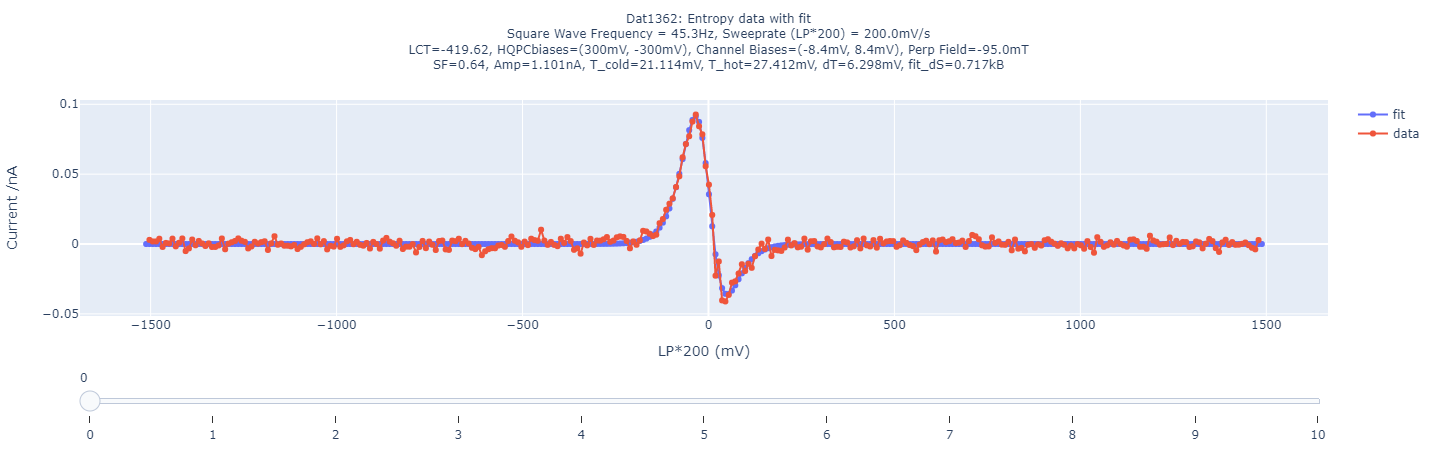

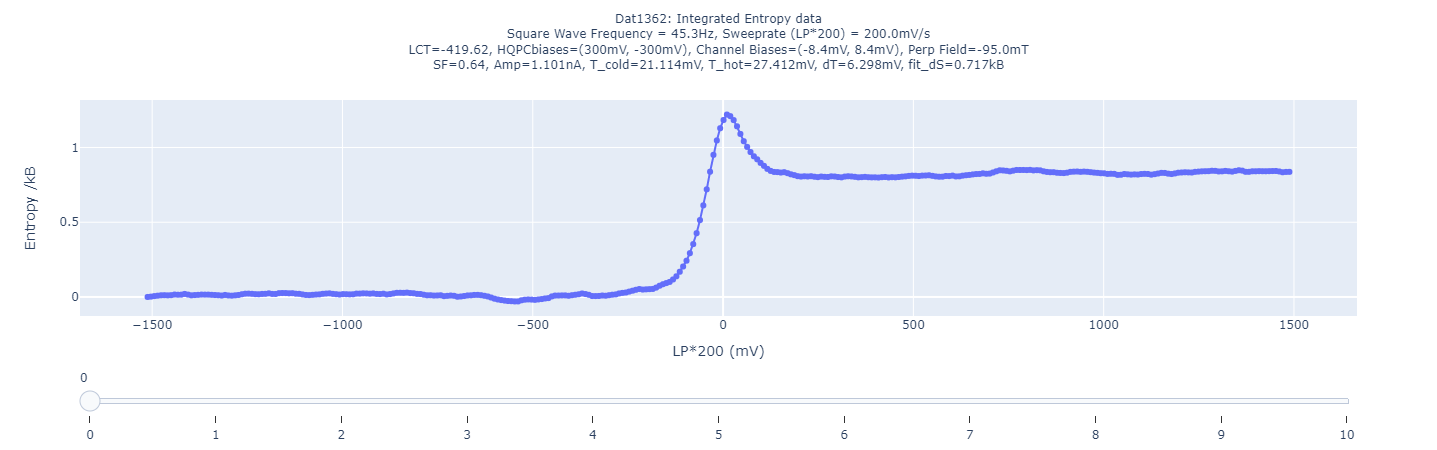

In [4]:
titles = EA_titles()
for pair in dat_pairs:
    dat = pair[0]
    values = getattr(dat.Other, 'EA_values', None)
    if values:
        scan_freq = dat.Logs.Fastdac.measure_freq / dat.AWG.info.wave_len
        fit_text = f'SF={values.sf:.2f}, Amp={values.amp:.3f}nA, T_cold={values.tc:.3f}mV, T_hot={values.th:.3f}mV, dT={values.dT:.3f}mV, fit_dS={values.efit_info.best_values.dS:.3f}kB'
        scan_text = f'LCT={dat.Logs.fds["LCT"]}, HQPCbiases=({dat.AWG.AWs[0][0][1]:.0f}mV, {dat.AWG.AWs[0][0][3]:.0f}mV), Channel Biases=({dat.AWG.AWs[1][0][1]:.1f}mV, {dat.AWG.AWs[1][0][3]:.1f}mV), Perp Field={dat.Logs.magy.field:.1f}mT'
        array_text = f'Square Wave Frequency = {scan_freq:.1f}Hz, Sweeprate (LP*200) = {dat.Logs.sweeprate:.1f}mV/s'
        text_info = f'{array_text}<br>{scan_text}<br>{fit_text}'
        titles.trans.append(f'Dat{dat.datnum}: Averaged CS data<br>{text_info}')
        titles.entropy.append(f'Dat{dat.datnum}: Entropy data with fit<br>{text_info}')
        titles.integrated.append(f'Dat{dat.datnum}: Integrated Entropy data<br>{text_info}')
    else:
        root_logger.warning(f'Dat{dat.datnum} has no dat.Other.EA_values attr, probably need to rerun processing')

datas = EA_datas.from_dats(dats)
datas.add_fit_to_entropys([p[0].Other.EA_values.efit_info for p in dat_pairs])

dat = dats[0]

fig1 = PlU.get_figure(datas=datas.trans_datas, xs=datas.xs, ids=titles.ids, titles=titles.trans, labels=['v0_0', 'vp', 'v0_1', 'vm'],
                      xlabel=f'{dat.Logs.x_label}', ylabel='Current /nA', plot_kwargs={'mode': 'lines+markers'})
fig2 = PlU.get_figure(datas=datas.entropy_datas, xs=datas.xs, ids=titles.ids, titles=titles.entropy, labels=['fit', 'data'],
                      xlabel=f'{dat.Logs.x_label}', ylabel='Current /nA', plot_kwargs={'mode': 'lines+markers'})
fig3 = PlU.get_figure(datas=datas.integrated_datas, xs=datas.xs, ids=titles.ids, titles=titles.integrated,
                      xlabel=f'{dat.Logs.x_label}', ylabel='Entropy /kB', plot_kwargs={'mode': 'lines+markers'})

for fig, name in zip([fig1, fig2, fig3], ['AveragedCS_vs_Channel_bias', 'Average_Entropy_With_Fit', 'Averaged_Integrated_Entropy']):
    fig.update_layout(hovermode = 'x unified',
                 title=dict(y=0.95,x=0.5,xanchor='center',yanchor='top', font=dict(size=12)))
    fig.show()

In [5]:
dat.Other.EA_values.efit_info